In [1]:
import pandas as pd
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow import  keras
from tensorflow.keras import layers, models

In [2]:
df =pd.read_csv("dataset_file_directory.csv")


In [3]:
p3_dataset =df[df['Participant']== 'P03']
p3_datasets =p3_dataset[~p3_dataset['Label'].isin([ 'laugh','glee'])]

In [4]:
classess=p3_datasets['Label'].value_counts()

In [5]:
classess

dysregulated    302
request          61
selftalk         55
frustrated       47
delighted        25
protest          20
Name: Label, dtype: int64

In [6]:
p3_datasets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510 entries, 2265 to 2781
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Filename     510 non-null    object
 1   Participant  510 non-null    object
 2   Label        510 non-null    object
dtypes: object(3)
memory usage: 15.9+ KB


In [7]:
# Specify the directory where your Python script is located
script_dir = r"C:\Users\pawan\Desktop\mv\downloaddataset"
# Define the relative path to the WAV files directory
wav_dir = os.path.join(script_dir, "downloaded_wav_files")

In [8]:
def extract_audio_features(dataset):
    null_file = 0
    
    for index, row in dataset.iterrows():
        filename = row['Filename']
        participant = row['Participant']
        label = row['Label']
        wav_file_path = os.path.join(wav_dir, filename)

        # Check if the audio file exists before attempting to load it
        if os.path.exists(wav_file_path):
            try:
                # Load the WAV file using librosa
                audio_data, sample_rate = librosa.load(wav_file_path, sr=None) 
                # Perform feature extraction (e.g., MFCCs)
                mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=50)
                chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)
                spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sample_rate)
                mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=13)
                stft = librosa.stft(audio_data)
                fft_features = np.abs(stft)
                rmse = librosa.feature.rms(y=audio_data)
                
                fft_features_db = librosa.amplitude_to_db(fft_features, ref=np.max)

            # Calculate the mean of FFT features
                fft_features_mean = np.mean(fft_features_db, axis=1)
                rmse_mean = np.mean(rmse)
                mfccs_mean = np.mean(mfccs, axis=1)
                chroma_mean = np.mean(chroma, axis=1)
                spectral_contrast_mean = np.mean(spectral_contrast, axis=1)
                mel_spectrogram_mean = np.mean(mel_spectrogram, axis=1)
                
                # Combine the extracted features into a single vector
                combined_mmcs=np.hstack((mfccs_mean,mel_spectrogram_mean,chroma_mean,spectral_contrast_mean))
                combined_feature_vector = np.hstack((mfccs_mean, chroma_mean, spectral_contrast_mean, mel_spectrogram_mean, fft_features_mean, rmse_mean))
                mf_mel=np.hstack((mfccs_mean,mel_spectrogram_mean))
                mf_co=np.hstack((mfccs_mean,chroma_mean))
                mf_ch=np.hstack((mfccs_mean,spectral_contrast_mean))
                # Append the extracted features and label to the lists
                mf_ch_list.append(mf_mel)
                mf_co_list.append(mf_ch)
                mf_mel_list.append(mf_co)
                mfcc_fe.append(mfccs_mean)
                rmse_fe.append(rmse_mean)
                chroma_fe.append(chroma_mean)
                spectral_constrast_fe.append(spectral_contrast_mean)
                mel_spectrogram_fe.append(mel_spectrogram_mean)
                fft_fe.append(fft_features_mean)
                combined_4.append(combined_mmcs)
                combined_fe.append(combined_feature_vector)
                labels_list.append(label)

            except Exception as e:
                print(f"Error processing {wav_file_path}: {str(e)}")
        else:
            null_file += 1
            print(f"Audio file not found: {wav_file_path}")

    print("Related audio files not found count:", null_file)

    return null_file


In [9]:
mfcc_fe=[]
rmse_fe=[]
chroma_fe=[]
spectral_constrast_fe=[]
mel_spectrogram_fe=[]
fft_fe=[]

#fusion of mfcc+mel,fusion of mfcc + contrast,mfcc+chroma
mf_ch_list=[]
mf_co_list=[]
mf_mel_list=[]
combined_4=[]
labels_list=[]
combined_fe=[]
extract_audio_features(p3_datasets)


Related audio files not found count: 0


0

In [10]:
X_mfcc_fe  = np.array(mfcc_fe)
X_rmse_fe  = np.array(rmse_fe)
X_chroma_fe  = np.array(chroma_fe)
X_spectral_constrast_fe= np.array(spectral_constrast_fe)
X_mel_spectrogram_fe= np.array(mel_spectrogram_fe)
X_fft_fe= np.array(fft_fe)

X_mf_ch=np.array(mf_ch_list)
X_mf_co=np.array(mf_co_list)
X_mf_mel=np.array(mf_mel_list)
X_combined=np.array(combined_4)

y=np.array(labels_list)

In [11]:
X_mel_spectrogram_fe.shape

(510, 13)

In [12]:
# Encode the labels
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


X_train_mfccs, X_test_mfccs, y_train1, y_test1 = train_test_split(X_mfcc_fe, y_encoded, test_size=0.2, random_state=42)
X_train_chroma, X_test_chroma, _, _ = train_test_split(X_chroma_fe, y_encoded, test_size=0.2, random_state=42)
X_train_spectral_contrast, X_test_spectral_contrast, _, _ = train_test_split(X_spectral_constrast_fe, y_encoded, test_size=0.2, random_state=42)
X_train_mel_spectrogram, X_test_mel_spectrogram, _, _ = train_test_split(X_mel_spectrogram_fe, y_encoded, test_size=0.2, random_state=42)
X_train_fft, X_test_fft, _, _ = train_test_split(X_fft_fe, y_encoded, test_size=0.2, random_state=42)
X_train_rmse, X_test_rmse, _, _ = train_test_split(X_rmse_fe, y_encoded, test_size=0.2, random_state=42)

X_mf_ch_train, X_mf_ch_test, _,_ = train_test_split(X_mf_ch, y_encoded, test_size=0.2, random_state=42)
X_mf_co_train, X_mf_co_test, _, _ = train_test_split(X_mf_co, y_encoded, test_size=0.2, random_state=42)
X_mf_mel_train, X_mf_mel_test, _, _ = train_test_split(X_mf_mel, y_encoded, test_size=0.2, random_state=42)
X_combined_train, X_combined_test, _, _ = train_test_split(X_combined, y_encoded, test_size=0.2, random_state=42)



In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
def cnn_model(X_train,y_train,X_test,y_test):
    n_classes=p3_datasets['Label'].nunique()
    model = models.Sequential([
        layers.Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
    
        # Add more convolutional layers
        layers.Conv1D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
    
        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
    
        layers.Conv1D(256, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
    
        layers.Flatten(),
    
        # Add more dense layers
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),  # Dropout layer to reduce overfitting
    
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
    
        layers.Dense(n_classes, activation='softmax') 
    ])
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=50, 
                   validation_split=0.2, 
                    batch_size=45)
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    accuracy_stack.append(test_accuracy)
    print(f"Test accuracy: {test_accuracy}")
    
    return model


def create_cnn_model(input_shape, num_classes):
    model = keras.Sequential([
        layers.Reshape((input_shape, 1), input_shape=(input_shape, )),  # Reshape for 1D convolution

        # Convolutional layers
        layers.Conv1D(64, 3, activation='relu', padding='same'),
        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.Conv1D(256, 3, activation='relu', padding='same'),

        # Flatten layer
        layers.Flatten(),

        # Fully connected layers
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [14]:
accuracy_stack=[]

In [15]:

cnn_model(X_train_mfccs,y_train1,X_test_mfccs,y_test1)

Epoch 1/50
8/8 [==============================] - 4s 161ms/step - loss: 3.6703 - accuracy: 0.3896 - val_loss: 1.3094 - val_accuracy: 0.6341
Epoch 2/50
8/8 [==============================] - 0s 39ms/step - loss: 1.7827 - accuracy: 0.4049 - val_loss: 1.2525 - val_accuracy: 0.6341
Epoch 3/50
8/8 [==============================] - 0s 31ms/step - loss: 1.4125 - accuracy: 0.5429 - val_loss: 1.1644 - val_accuracy: 0.6341
Epoch 4/50
8/8 [==============================] - 0s 33ms/step - loss: 1.3106 - accuracy: 0.5583 - val_loss: 1.1507 - val_accuracy: 0.6341
Epoch 5/50
8/8 [==============================] - 0s 32ms/step - loss: 1.2863 - accuracy: 0.5491 - val_loss: 1.0884 - val_accuracy: 0.6341
Epoch 6/50
8/8 [==============================] - 0s 31ms/step - loss: 1.3243 - accuracy: 0.5706 - val_loss: 1.1076 - val_accuracy: 0.6585
Epoch 7/50
8/8 [==============================] - 0s 29ms/step - loss: 1.2577 - accuracy: 0.5644 - val_loss: 1.0791 - val_accuracy: 0.6585
Epoch 8/50
8/8 [==========

In [16]:
cnn_model(X_train_chroma,y_train1,X_test_chroma,y_test1)

Epoch 1/50
8/8 [==============================] - 4s 163ms/step - loss: 1.6672 - accuracy: 0.5215 - val_loss: 1.3101 - val_accuracy: 0.6341
Epoch 2/50
8/8 [==============================] - 0s 29ms/step - loss: 1.4025 - accuracy: 0.5828 - val_loss: 1.2301 - val_accuracy: 0.6341
Epoch 3/50
8/8 [==============================] - 0s 21ms/step - loss: 1.3274 - accuracy: 0.5828 - val_loss: 1.2541 - val_accuracy: 0.6341
Epoch 4/50
8/8 [==============================] - 0s 24ms/step - loss: 1.2956 - accuracy: 0.5828 - val_loss: 1.2004 - val_accuracy: 0.6341
Epoch 5/50
8/8 [==============================] - 0s 21ms/step - loss: 1.2882 - accuracy: 0.5828 - val_loss: 1.1845 - val_accuracy: 0.6341
Epoch 6/50
8/8 [==============================] - 0s 21ms/step - loss: 1.2932 - accuracy: 0.5828 - val_loss: 1.1420 - val_accuracy: 0.6341
Epoch 7/50
8/8 [==============================] - 0s 26ms/step - loss: 1.2626 - accuracy: 0.5828 - val_loss: 1.1142 - val_accuracy: 0.6341
Epoch 8/50
8/8 [==========

In [17]:
cnn_model(X_train_mel_spectrogram,y_train1,X_test_mel_spectrogram,y_test1)

Epoch 1/50
8/8 [==============================] - 4s 157ms/step - loss: 2.0245 - accuracy: 0.4141 - val_loss: 1.4847 - val_accuracy: 0.6463
Epoch 2/50
8/8 [==============================] - 0s 32ms/step - loss: 1.6308 - accuracy: 0.4847 - val_loss: 1.4133 - val_accuracy: 0.6463
Epoch 3/50
8/8 [==============================] - 0s 26ms/step - loss: 1.5792 - accuracy: 0.5583 - val_loss: 1.3990 - val_accuracy: 0.6463
Epoch 4/50
8/8 [==============================] - 0s 25ms/step - loss: 1.5147 - accuracy: 0.5552 - val_loss: 1.3882 - val_accuracy: 0.6463
Epoch 5/50
8/8 [==============================] - 0s 25ms/step - loss: 1.4973 - accuracy: 0.5767 - val_loss: 1.3690 - val_accuracy: 0.6463
Epoch 6/50
8/8 [==============================] - 0s 25ms/step - loss: 1.4319 - accuracy: 0.6074 - val_loss: 1.3409 - val_accuracy: 0.6463
Epoch 7/50
8/8 [==============================] - 0s 27ms/step - loss: 1.4360 - accuracy: 0.5951 - val_loss: 1.2950 - val_accuracy: 0.6463
Epoch 8/50
8/8 [==========

In [18]:

cnn_model(X_train_fft, y_train1, X_test_fft, y_test1)


Epoch 1/50
8/8 [==============================] - 7s 335ms/step - loss: 14.0857 - accuracy: 0.3129 - val_loss: 1.3540 - val_accuracy: 0.6341
Epoch 2/50
8/8 [==============================] - 2s 243ms/step - loss: 1.7777 - accuracy: 0.3834 - val_loss: 1.4549 - val_accuracy: 0.6341
Epoch 3/50
8/8 [==============================] - 2s 231ms/step - loss: 1.5382 - accuracy: 0.5031 - val_loss: 1.4387 - val_accuracy: 0.6341
Epoch 4/50
8/8 [==============================] - 2s 230ms/step - loss: 1.4637 - accuracy: 0.5644 - val_loss: 1.3184 - val_accuracy: 0.6341
Epoch 5/50
8/8 [==============================] - 2s 271ms/step - loss: 1.4970 - accuracy: 0.5644 - val_loss: 1.2419 - val_accuracy: 0.6341
Epoch 6/50
8/8 [==============================] - 2s 261ms/step - loss: 1.4469 - accuracy: 0.5798 - val_loss: 1.2241 - val_accuracy: 0.6341
Epoch 7/50
8/8 [==============================] - 2s 249ms/step - loss: 1.4456 - accuracy: 0.5675 - val_loss: 1.3461 - val_accuracy: 0.6341
Epoch 8/50
8/8 [===

In [19]:
X_train_rmse.shape


(408,)

In [21]:

model2=create_cnn_model(1,6)
history = model2.fit(X_train_rmse, y_train1, epochs=10, 
                   validation_split=0.2, 
                    batch_size=45)

test_loss, test_accuracy = model2.evaluate(X_test_rmse, y_test1)

accuracy_stack.append(test_accuracy)
print(f"Test accuracy: {test_accuracy}")

Epoch 1/10
8/8 [==============================] - 1s 58ms/step - loss: 1.7658 - accuracy: 0.5399 - val_loss: 1.6911 - val_accuracy: 0.6341
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 1.6143 - accuracy: 0.5828 - val_loss: 1.3978 - val_accuracy: 0.6341
Epoch 3/10
8/8 [==============================] - 0s 16ms/step - loss: 1.4353 - accuracy: 0.5828 - val_loss: 1.2711 - val_accuracy: 0.6341
Epoch 4/10
8/8 [==============================] - 0s 13ms/step - loss: 1.3639 - accuracy: 0.5828 - val_loss: 1.2639 - val_accuracy: 0.6341
Epoch 5/10
8/8 [==============================] - 0s 11ms/step - loss: 1.3541 - accuracy: 0.5828 - val_loss: 1.2569 - val_accuracy: 0.6341
Epoch 6/10
8/8 [==============================] - 0s 13ms/step - loss: 1.3504 - accuracy: 0.5828 - val_loss: 1.2451 - val_accuracy: 0.6341
Epoch 7/10
8/8 [==============================] - 0s 13ms/step - loss: 1.3502 - accuracy: 0.5828 - val_loss: 1.2537 - val_accuracy: 0.6341
Epoch 8/10
8/8 [===========

In [22]:


model1=create_cnn_model(7,6)
history = model1.fit(X_train_spectral_contrast, y_train1, epochs=10, 
                   validation_split=0.2, 
                    batch_size=45)

test_loss, test_accuracy = model1.evaluate(X_test_spectral_contrast, y_test1)

accuracy_stack.append(test_accuracy)
print(f"Test accuracy: {test_accuracy}")


Epoch 1/10
8/8 [==============================] - 1s 61ms/step - loss: 2.4466 - accuracy: 0.3466 - val_loss: 1.2694 - val_accuracy: 0.6341
Epoch 2/10
8/8 [==============================] - 0s 19ms/step - loss: 1.4853 - accuracy: 0.5000 - val_loss: 1.2314 - val_accuracy: 0.6341
Epoch 3/10
8/8 [==============================] - 0s 18ms/step - loss: 1.4381 - accuracy: 0.5613 - val_loss: 1.2354 - val_accuracy: 0.6341
Epoch 4/10
8/8 [==============================] - 0s 16ms/step - loss: 1.3315 - accuracy: 0.5798 - val_loss: 1.2289 - val_accuracy: 0.6341
Epoch 5/10
8/8 [==============================] - 0s 18ms/step - loss: 1.3651 - accuracy: 0.5767 - val_loss: 1.2115 - val_accuracy: 0.6341
Epoch 6/10
8/8 [==============================] - 0s 16ms/step - loss: 1.3400 - accuracy: 0.5828 - val_loss: 1.1757 - val_accuracy: 0.6341
Epoch 7/10
8/8 [==============================] - 0s 16ms/step - loss: 1.3349 - accuracy: 0.5828 - val_loss: 1.2177 - val_accuracy: 0.6341
Epoch 8/10
8/8 [===========

In [23]:
cnn_model(X_mf_ch_train,y_train1,X_mf_ch_test,y_test1)

Epoch 1/50
8/8 [==============================] - 1s 67ms/step - loss: 4.7681 - accuracy: 0.3436 - val_loss: 1.3033 - val_accuracy: 0.6341
Epoch 2/50
8/8 [==============================] - 0s 19ms/step - loss: 1.9697 - accuracy: 0.4601 - val_loss: 1.2423 - val_accuracy: 0.6341
Epoch 3/50
8/8 [==============================] - 0s 22ms/step - loss: 1.4131 - accuracy: 0.4693 - val_loss: 1.2070 - val_accuracy: 0.6341
Epoch 4/50
8/8 [==============================] - 0s 20ms/step - loss: 1.3355 - accuracy: 0.5153 - val_loss: 1.1553 - val_accuracy: 0.6341
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 1.3456 - accuracy: 0.5460 - val_loss: 1.1323 - val_accuracy: 0.6341
Epoch 6/50
8/8 [==============================] - 0s 20ms/step - loss: 1.2924 - accuracy: 0.5552 - val_loss: 1.0497 - val_accuracy: 0.6341
Epoch 7/50
8/8 [==============================] - 0s 19ms/step - loss: 1.2132 - accuracy: 0.5644 - val_loss: 1.0368 - val_accuracy: 0.6341
Epoch 8/50
8/8 [===========

In [24]:
cnn_model(X_mf_co_train,y_train1,X_mf_co_test,y_test1)

Epoch 1/50
8/8 [==============================] - 1s 67ms/step - loss: 3.6259 - accuracy: 0.4049 - val_loss: 1.2354 - val_accuracy: 0.6341
Epoch 2/50
8/8 [==============================] - 0s 20ms/step - loss: 1.9474 - accuracy: 0.4294 - val_loss: 1.2124 - val_accuracy: 0.6341
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 1.4999 - accuracy: 0.5000 - val_loss: 1.1668 - val_accuracy: 0.6341
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 1.3524 - accuracy: 0.5307 - val_loss: 1.1510 - val_accuracy: 0.6341
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 1.3004 - accuracy: 0.5767 - val_loss: 1.0841 - val_accuracy: 0.6463
Epoch 6/50
8/8 [==============================] - 0s 20ms/step - loss: 1.2312 - accuracy: 0.5982 - val_loss: 1.1073 - val_accuracy: 0.6463
Epoch 7/50
8/8 [==============================] - 0s 20ms/step - loss: 1.1967 - accuracy: 0.6135 - val_loss: 1.0624 - val_accuracy: 0.6463
Epoch 8/50
8/8 [===========

In [25]:
cnn_model(X_mf_mel_train,y_train1,X_mf_mel_test,y_test1)

Epoch 1/50
8/8 [==============================] - 1s 67ms/step - loss: 4.9835 - accuracy: 0.3804 - val_loss: 1.3770 - val_accuracy: 0.6341
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 2.2604 - accuracy: 0.4387 - val_loss: 1.4025 - val_accuracy: 0.6341
Epoch 3/50
8/8 [==============================] - 0s 20ms/step - loss: 1.5204 - accuracy: 0.4693 - val_loss: 1.2888 - val_accuracy: 0.6341
Epoch 4/50
8/8 [==============================] - 0s 20ms/step - loss: 1.3749 - accuracy: 0.5368 - val_loss: 1.1781 - val_accuracy: 0.6341
Epoch 5/50
8/8 [==============================] - 0s 22ms/step - loss: 1.2957 - accuracy: 0.5767 - val_loss: 1.1980 - val_accuracy: 0.6341
Epoch 6/50
8/8 [==============================] - 0s 18ms/step - loss: 1.3239 - accuracy: 0.5613 - val_loss: 1.1464 - val_accuracy: 0.6341
Epoch 7/50
8/8 [==============================] - 0s 20ms/step - loss: 1.2164 - accuracy: 0.5920 - val_loss: 1.1167 - val_accuracy: 0.6341
Epoch 8/50
8/8 [===========

In [26]:
cnn_model(X_combined_train,y_train1,X_combined_test,y_test1)

Epoch 1/50
8/8 [==============================] - 1s 71ms/step - loss: 5.1336 - accuracy: 0.3742 - val_loss: 1.3597 - val_accuracy: 0.6341
Epoch 2/50
8/8 [==============================] - 0s 22ms/step - loss: 2.0044 - accuracy: 0.4601 - val_loss: 1.2522 - val_accuracy: 0.6341
Epoch 3/50
8/8 [==============================] - 0s 21ms/step - loss: 1.5150 - accuracy: 0.4847 - val_loss: 1.2198 - val_accuracy: 0.6341
Epoch 4/50
8/8 [==============================] - 0s 20ms/step - loss: 1.3036 - accuracy: 0.5491 - val_loss: 1.1940 - val_accuracy: 0.6341
Epoch 5/50
8/8 [==============================] - 0s 22ms/step - loss: 1.2909 - accuracy: 0.5644 - val_loss: 1.1668 - val_accuracy: 0.6341
Epoch 6/50
8/8 [==============================] - 0s 20ms/step - loss: 1.2274 - accuracy: 0.6074 - val_loss: 1.1449 - val_accuracy: 0.6341
Epoch 7/50
8/8 [==============================] - 0s 22ms/step - loss: 1.1722 - accuracy: 0.6074 - val_loss: 1.0662 - val_accuracy: 0.6341
Epoch 8/50
8/8 [===========

In [27]:
accuracy_stack

[0.7549019455909729,
 0.6274510025978088,
 0.656862735748291,
 0.7254902124404907,
 0.5882353186607361,
 0.5882353186607361,
 0.7352941036224365,
 0.7352941036224365,
 0.7843137383460999,
 0.7450980544090271]

In [28]:
labels=p3_datasets['Label'].unique()

In [ ]:
labels

In [29]:
import time
import matplotlib.pyplot as plt
# Define a function to train and evaluate a CNN model
def train_evaluate_cnn_model(X_train, y_train, X_test, y_test, input_shape, num_classes, epochs=10):
    start_time = time.time()

    model = create_cnn_model(input_shape, num_classes)
    history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, batch_size=45)
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    end_time = time.time()

    return model, history, test_accuracy, end_time - start_time

# List of models and their input shapes
models_to_evaluate = [
    (X_train_mfccs, y_train1, X_test_mfccs, y_test1, X_train_mfccs.shape[1], len(set(labels))),
    (X_train_chroma, y_train1, X_test_chroma, y_test1, X_train_chroma.shape[1], len(set(labels))),
    (X_train_mel_spectrogram, y_train1, X_test_mel_spectrogram, y_test1, X_train_mel_spectrogram.shape[1], len(set(labels))),
    (X_train_fft, y_train1, X_test_fft, y_test1, X_train_fft.shape[1], len(set(labels))),
    (X_train_rmse, y_train1, X_test_rmse, y_test1, 1, len(set(labels))),
    (X_train_spectral_contrast, y_train1, X_test_spectral_contrast, y_test1,7, len(set(labels))),
    (X_mf_ch_train, y_train1, X_mf_ch_test, y_test1, X_mf_ch_train.shape[1], len(set(labels))),
    (X_mf_co_train, y_train1, X_mf_co_test, y_test1, X_mf_co_train.shape[1], len(set(labels))),
    (X_mf_mel_train, y_train1, X_mf_mel_test, y_test1, X_mf_mel_train.shape[1], len(set(labels))),
    (X_combined_train, y_train1, X_combined_test, y_test1, X_combined_train.shape[1], len(set(labels)))
]

# Train and evaluate models, and collect their accuracies and execution times
model_accuracies = []
execution_times = []

for X_train, y_train, X_test, y_test, input_shape, num_classes in models_to_evaluate:
    model, _, test_accuracy, execution_time = train_evaluate_cnn_model(X_train, y_train, X_test, y_test, input_shape, num_classes)
    model_accuracies.append(test_accuracy)
    execution_times.append(execution_time)



Epoch 1/10
8/8 [==============================] - 1s 83ms/step - loss: 4.5118 - accuracy: 0.3558 - val_loss: 1.2517 - val_accuracy: 0.6341
Epoch 2/10
8/8 [==============================] - 0s 34ms/step - loss: 1.4791 - accuracy: 0.4509 - val_loss: 1.1083 - val_accuracy: 0.6341
Epoch 3/10
8/8 [==============================] - 0s 34ms/step - loss: 1.3186 - accuracy: 0.5767 - val_loss: 1.1655 - val_accuracy: 0.6463
Epoch 4/10
8/8 [==============================] - 0s 36ms/step - loss: 1.2047 - accuracy: 0.5890 - val_loss: 1.0191 - val_accuracy: 0.6585
Epoch 5/10
8/8 [==============================] - 0s 36ms/step - loss: 1.1884 - accuracy: 0.6135 - val_loss: 1.0417 - val_accuracy: 0.6951
Epoch 6/10
8/8 [==============================] - 0s 40ms/step - loss: 1.0989 - accuracy: 0.6472 - val_loss: 0.9478 - val_accuracy: 0.6951
Epoch 7/10
8/8 [==============================] - 0s 38ms/step - loss: 1.0445 - accuracy: 0.6288 - val_loss: 0.9451 - val_accuracy: 0.6829
Epoch 8/10
8/8 [===========

Epoch 7/10
8/8 [==============================] - 0s 16ms/step - loss: 1.3581 - accuracy: 0.5859 - val_loss: 1.2832 - val_accuracy: 0.6341
Epoch 8/10
8/8 [==============================] - 0s 13ms/step - loss: 1.3415 - accuracy: 0.5798 - val_loss: 1.2226 - val_accuracy: 0.6341
Epoch 9/10
8/8 [==============================] - 0s 18ms/step - loss: 1.2850 - accuracy: 0.5859 - val_loss: 1.1651 - val_accuracy: 0.6341
Epoch 10/10
4/4 [==============================] - 0s 5ms/step - loss: 1.2409 - accuracy: 0.5882
Epoch 1/10
8/8 [==============================] - 1s 87ms/step - loss: 4.1274 - accuracy: 0.3712 - val_loss: 1.3178 - val_accuracy: 0.6341
Epoch 2/10
8/8 [==============================] - 0s 43ms/step - loss: 1.4105 - accuracy: 0.5245 - val_loss: 1.1291 - val_accuracy: 0.6341
Epoch 3/10
8/8 [==============================] - 0s 40ms/step - loss: 1.2681 - accuracy: 0.5828 - val_loss: 1.0592 - val_accuracy: 0.6707
Epoch 4/10
8/8 [==============================] - 0s 42ms/step - loss

In [30]:
print(model_accuracies)
print(" ")
print(accuracy_stack)

[0.686274528503418, 0.6274510025978088, 0.6078431606292725, 0.5882353186607361, 0.5882353186607361, 0.5882353186607361, 0.7647058963775635, 0.6470588445663452, 0.7058823704719543, 0.7058823704719543]
 
[0.7549019455909729, 0.6274510025978088, 0.656862735748291, 0.7254902124404907, 0.5882353186607361, 0.5882353186607361, 0.7352941036224365, 0.7352941036224365, 0.7843137383460999, 0.7450980544090271]


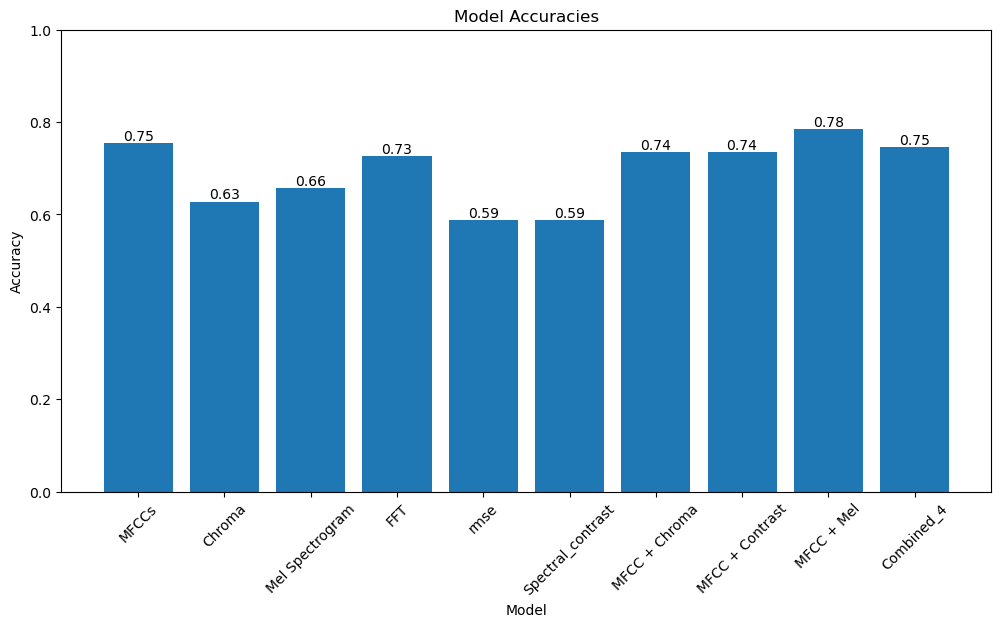

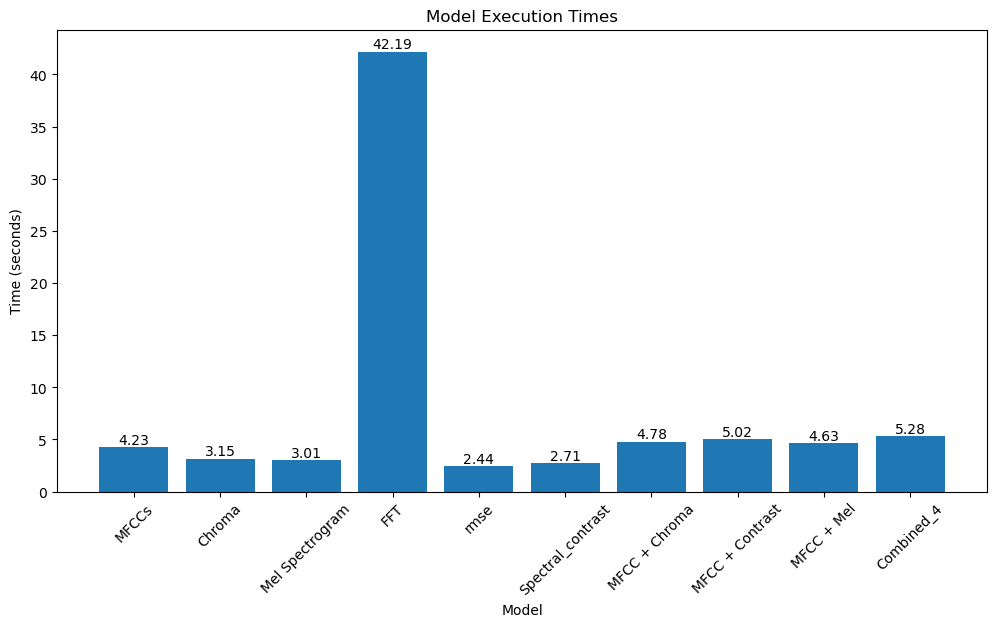

In [32]:

# Plot model accuracies
model_names = [
    "MFCCs", "Chroma", "Mel Spectrogram", "FFT","rmse","Spectral_contrast",
    "MFCC + Chroma", "MFCC + Contrast", "MFCC + Mel","Combined_4"
]

plt.figure(figsize=(12, 6))
bars = plt.bar(model_names, accuracy_stack)
plt.title("Model Accuracies person-p03")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Annotate each bar with its accuracy value
for bar, accuracy in zip(bars, accuracy_stack):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{accuracy:.2f}', ha='center', va='bottom')

plt.show()
# Plot execution times
plt.figure(figsize=(12, 6))
bar1=plt.bar(model_names, execution_times)
plt.title("Model Execution Times")
plt.xlabel("Model")
plt.ylabel("Time (seconds)")
plt.xticks(rotation=45)
for bar1, time in zip(bar1, execution_times):
    plt.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height(), f'{time:.2f}', ha='center', va='bottom')

plt.show()
